# Stock prediction project  
## Predict the closing price of a stock for the next day based on historical data.  

# Gathering data

In [28]:
import yfinance as yf
import pandas as pd

# Define the stock symbol and the timeframe for desired data
stock_symbol = "MSFT"  # Microsoft stock symbol
start_date = "2022-01-01"
end_date = "2023-01-01"

# Fetch historical stock data from Yahoo Finance
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Save the data
stock_data.to_csv('historical_stock_data.csv', index=True)


[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-01-03  335.350006  338.000000  329.779999  334.750000  328.727631   
2022-01-04  334.829987  335.200012  326.119995  329.010010  323.090973   
2022-01-05  325.859985  326.070007  315.980011  316.380005  310.688202   
2022-01-06  313.149994  318.700012  311.489990  313.880005  308.233093   
2022-01-07  314.149994  316.500000  310.089996  314.040009  308.390228   

              Volume  
Date                  
2022-01-03  28865100  
2022-01-04  32674300  
2022-01-05  40054300  
2022-01-06  39646100  
2022-01-07  32720000  


# Data exploration and visualization

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-01-03  335.350006  338.000000  329.779999  334.750000  328.727631   
2022-01-04  334.829987  335.200012  326.119995  329.010010  323.090973   
2022-01-05  325.859985  326.070007  315.980011  316.380005  310.688202   
2022-01-06  313.149994  318.700012  311.489990  313.880005  308.233093   
2022-01-07  314.149994  316.500000  310.089996  314.040009  308.390228   

              Volume  
Date                  
2022-01-03  28865100  
2022-01-04  32674300  
2022-01-05  40054300  
2022-01-06  39646100  
2022-01-07  32720000  


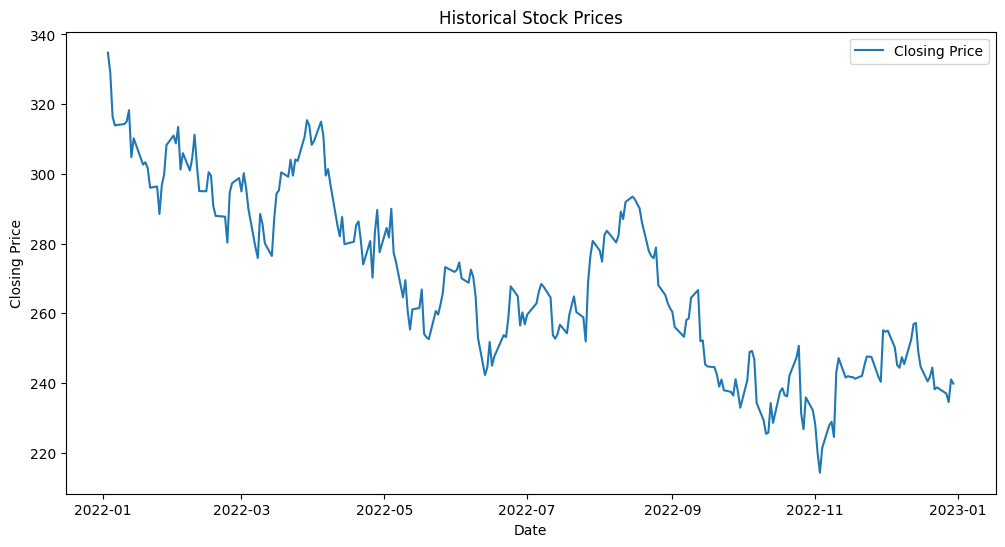

In [29]:
import matplotlib.pyplot as plt

print(stock_data.head())

# Visualize closing prices
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index, stock_data['Close'], label='Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Historical Stock Prices')
plt.legend()
plt.show()


# Feature engineering

In [30]:

# Load stock price data
stock_data = pd.read_csv('historical_stock_data.csv')

# Set the 'Date' column as index
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data = stock_data.set_index('Date')

# Create lagged features
stock_data['Close_Lag1'] = stock_data['Close'].shift(1)
stock_data['Close_Lag2'] = stock_data['Close'].shift(2)
stock_data['Close_Lag3'] = stock_data['Close'].shift(3)

# Create additional features - Moving Averages
stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['EMA_10'] = stock_data['Close'].ewm(span=10, adjust=False).mean()
stock_data['EMA_50'] = stock_data['Close'].ewm(span=50, adjust=False).mean()

# Create additional features - Relative Strength Index - RSI
window_length = 14
delta = stock_data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=window_length).mean()
avg_loss = loss.rolling(window=window_length).mean()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
stock_data['RSI'] = rsi

# Create additional features - Moving Average Convergence Divergence - MACD
short_window = 12
long_window = 26
short_ema = stock_data['Close'].ewm(span=short_window, adjust=False).mean()
long_ema = stock_data['Close'].ewm(span=long_window, adjust=False).mean()
macd_line = short_ema - long_ema
signal_line = macd_line.ewm(span=9, adjust=False).mean()
stock_data['MACD'] = macd_line
stock_data['Signal_Line'] = signal_line

# Drop rows with NaN values introduced by lagging and feature creation
stock_data = stock_data.dropna()



# Creating features
## Given the time series nature of the  data, its important to include time-aware cross-validation 

In [31]:
from sklearn.model_selection import TimeSeriesSplit


# Create features including lagged and additional ones
features = stock_data[['Open', 'High', 'Low', 'Close_Lag1', 'Close_Lag2', 'Close_Lag3',
                       'SMA_10', 'SMA_50', 'EMA_10', 'EMA_50', 'RSI', 'MACD', 'Signal_Line']]
target = stock_data['Close']

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Using Gradient Boosting model


Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50}
Cross-Validated RMSE for Gradient Boosting Model: 10.10228179133011
Cross-Validated MAE for Gradient Boosting Model: 6.883703409406522


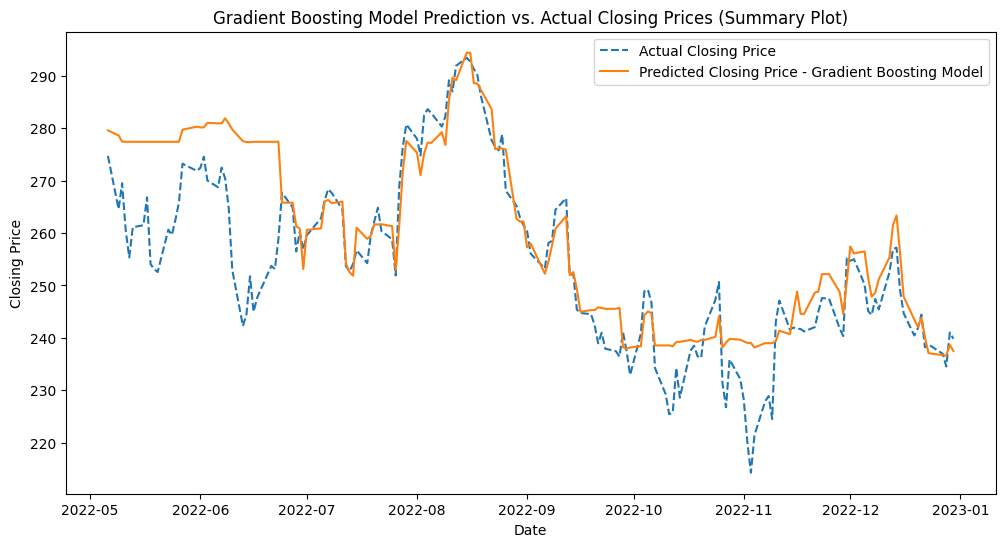

In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initialize the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(gb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model to the data
grid_search.fit(features, target)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Get the best performing model
best_gb_model = grid_search.best_estimator_

# Perform cross-validation
gb_cv_scores = cross_val_score(best_gb_model, features, target, cv=tscv, scoring='neg_mean_squared_error')

# RMSE from cross-validation scores - Root Mean Squared Error
gb_cv_rmse = np.sqrt(-gb_cv_scores.mean())
print(f"Cross-Validated RMSE for Gradient Boosting Model: {gb_cv_rmse}")

# MAE from cross-validation scores - Mean Absolute Error
gb_cv_mae_scores = cross_val_score(best_gb_model, features, target, cv=tscv, scoring='neg_mean_absolute_error')
gb_cv_mae = -gb_cv_mae_scores.mean()
print(f"Cross-Validated MAE for Gradient Boosting Model: {gb_cv_mae}")

# Visualize predictions vs. actual closing prices 
plt.figure(figsize=(12, 6))

# Initialize arrays to store predictions and actual values for every fold of cross-validation
all_gb_predictions = np.array([])
all_y_test = np.array([])

# Iterate over the cross-validation folds
for train_index, test_index in tscv.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    # Fit the model on the training set
    best_gb_model.fit(X_train, y_train)

    # Make predictions on the test set
    gb_predictions = best_gb_model.predict(X_test)

    # Store predictions and actual values
    all_gb_predictions = np.concatenate([all_gb_predictions, gb_predictions])
    all_y_test = np.concatenate([all_y_test, y_test])

# Plot the summary of actual and predicted closing prices
plt.plot(stock_data.index[-len(all_y_test):], all_y_test, label='Actual Closing Price', linestyle='--')
plt.plot(stock_data.index[-len(all_gb_predictions):], all_gb_predictions, label='Predicted Closing Price - Gradient Boosting Model')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Gradient Boosting Model Prediction vs. Actual Closing Prices')
plt.legend()
plt.show()


# Prediction using ensemble method - Random Forest Regressor

Best Parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Cross-Validated RMSE for Random Forest Model: 9.721881416772742
Cross-Validated MAE for Random Forest Model: 6.233405977609694


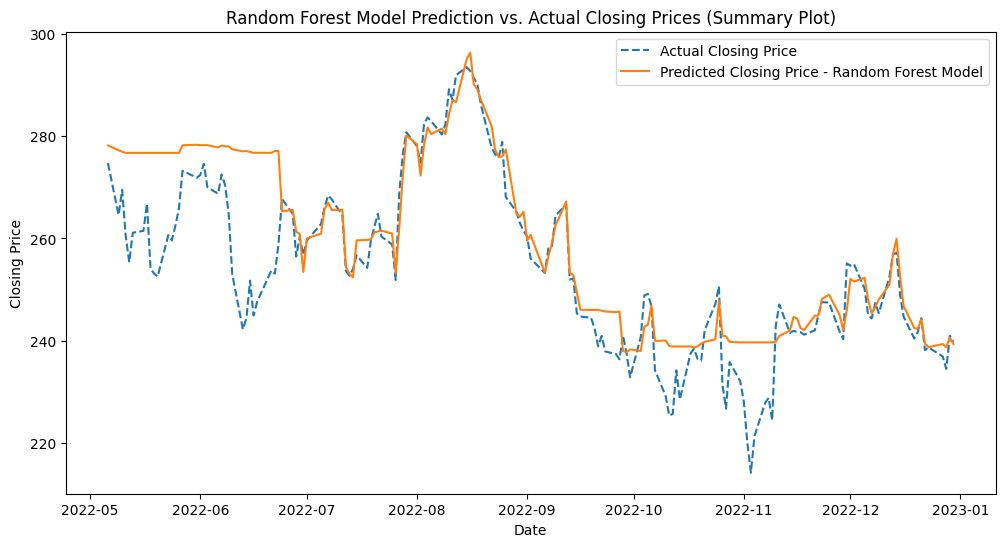

In [33]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None] 
}

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(rf_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model to the data
grid_search.fit(features, target)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Perform cross-validation
rf_cv_scores = cross_val_score(best_rf_model, features, target, cv=tscv, scoring='neg_mean_squared_error')

# RMSE
rf_cv_rmse = np.sqrt(-rf_cv_scores.mean())
print(f"Cross-Validated RMSE for Random Forest Model: {rf_cv_rmse}")

# MAE 
rf_cv_mae_scores = cross_val_score(best_rf_model, features, target, cv=tscv, scoring='neg_mean_absolute_error')
rf_cv_mae = -rf_cv_mae_scores.mean()
print(f"Cross-Validated MAE for Random Forest Model: {rf_cv_mae}")

# Visualize predictions vs. actual closing prices 
plt.figure(figsize=(12, 6))

# Initialize arrays to store predictions and actual values for all folds
all_rf_predictions = np.array([])
all_y_test = np.array([])

# Iterate over the cross-validation folds
for train_index, test_index in tscv.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    # Fit the model on the training set
    best_rf_model.fit(X_train, y_train)

    # Make predictions on the test set
    rf_predictions = best_rf_model.predict(X_test)

    # Store predictions and actual values
    all_rf_predictions = np.concatenate([all_rf_predictions, rf_predictions])
    all_y_test = np.concatenate([all_y_test, y_test])

# Plot the summary of actual and predicted closing prices
plt.plot(stock_data.index[-len(all_y_test):], all_y_test, label='Actual Closing Price', linestyle='--')
plt.plot(stock_data.index[-len(all_rf_predictions):], all_rf_predictions, label='Predicted Closing Price - Random Forest Model')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Random Forest Model Prediction vs. Actual Closing Prices')
plt.legend()
plt.show()



# Using ensemble method - XGBoost

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Cross-Validated RMSE for XGBoost Model: 9.350455702552456
Cross-Validated MAE for XGBoost Model: 5.977516035600141


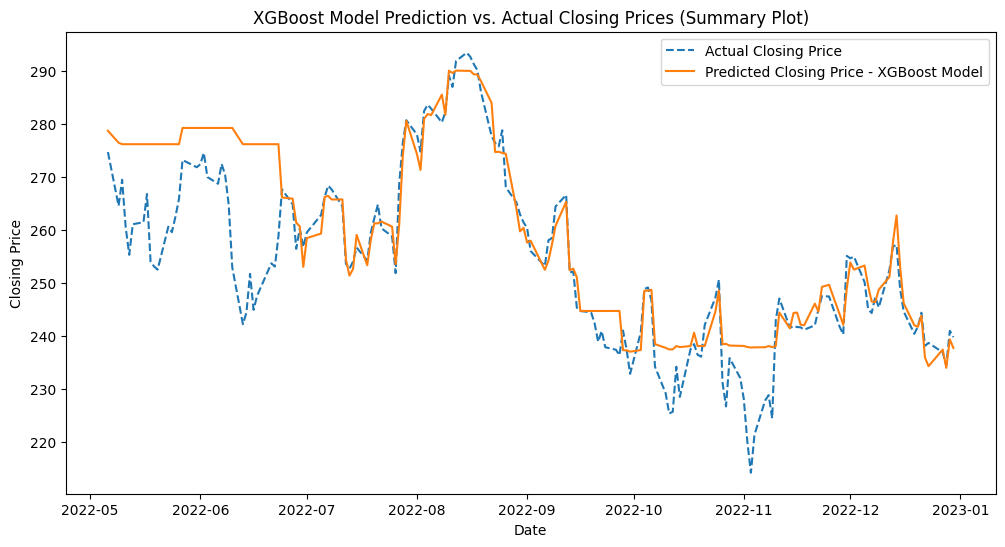

In [34]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initialize the XGBoost model
xgb_model = XGBRegressor(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model to the data
grid_search.fit(features, target)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Perform cross-validation
xgb_cv_scores = cross_val_score(
    best_xgb_model, features, target, cv=tscv, scoring='neg_mean_squared_error')

# RMSE
xgb_cv_rmse = np.sqrt(-xgb_cv_scores.mean())
print(f"Cross-Validated RMSE for XGBoost Model: {xgb_cv_rmse}")

# MAE
xgb_cv_mae_scores = cross_val_score(
    best_xgb_model, features, target, cv=tscv, scoring='neg_mean_absolute_error')
xgb_cv_mae = -xgb_cv_mae_scores.mean()
print(f"Cross-Validated MAE for XGBoost Model: {xgb_cv_mae}")

# Visualize predictions vs. actual closing prices 
plt.figure(figsize=(12, 6))

# Initialize arrays to store predictions and actual values for all folds
all_xgb_predictions = np.array([])
all_y_test = np.array([])

# Iterate over the cross-validation folds
for train_index, test_index in tscv.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    # Fit the model on the training set
    best_xgb_model.fit(X_train, y_train)

    # Make predictions on the test set
    xgb_predictions = best_xgb_model.predict(X_test)

    # Store predictions and actual values
    all_xgb_predictions = np.concatenate(
        [all_xgb_predictions, xgb_predictions])
    all_y_test = np.concatenate([all_y_test, y_test])

# Plot the summary of actual and predicted closing prices
plt.plot(stock_data.index[-len(all_y_test):], all_y_test,
         label='Actual Closing Price', linestyle='--')
plt.plot(stock_data.index[-len(all_xgb_predictions):],
         all_xgb_predictions, label='Predicted Closing Price - XGBoost Model')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('XGBoost Model Prediction vs. Actual Closing Prices')
plt.legend()
plt.show()

# Using SVM model since they yield relatively higher accuracy as they work well with datasets of high dimensionality [1].

Best Parameters: {'C': 1, 'epsilon': 0.01, 'kernel': 'linear'}
Cross-Validated RMSE for SVM Model: 1.2403775197269873
Cross-Validated MAE for SVM Model: 0.9593085003503212


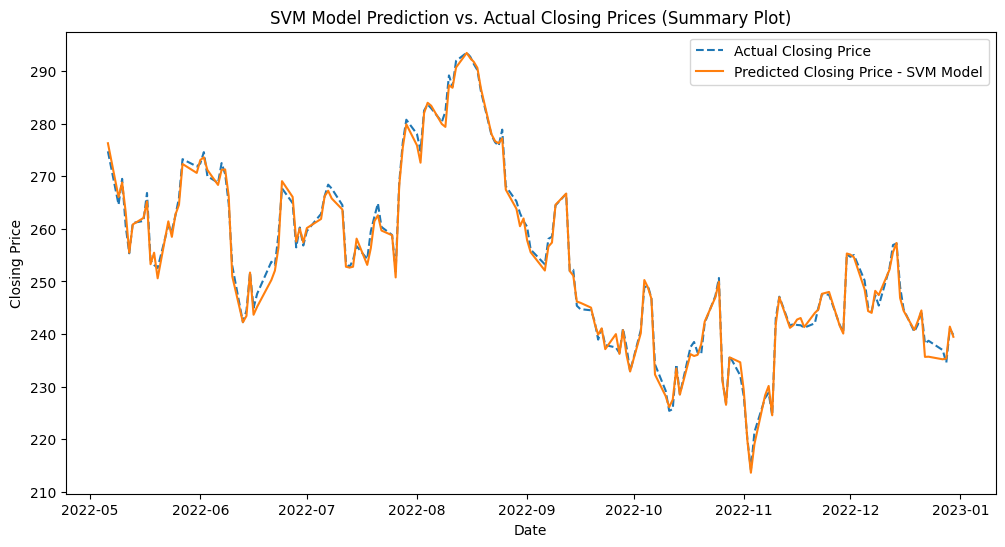

In [35]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['linear', 'rbf', 'poly']
}

# Initialize the SVM model
svm_model = SVR()

# Create the GridSearchCV object
grid_search = GridSearchCV(
    svm_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model to the data
grid_search.fit(features, target)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_svm_model = grid_search.best_estimator_

# Perform cross-validation
svm_cv_scores = cross_val_score(
    best_svm_model, features, target, cv=tscv, scoring='neg_mean_squared_error')

# RMSE
svm_cv_rmse = np.sqrt(-svm_cv_scores.mean())
print(f"Cross-Validated RMSE for SVM Model: {svm_cv_rmse}")

# MAE
svm_cv_mae_scores = cross_val_score(
    best_svm_model, features, target, cv=tscv, scoring='neg_mean_absolute_error')
svm_cv_mae = -svm_cv_mae_scores.mean()
print(f"Cross-Validated MAE for SVM Model: {svm_cv_mae}")

# Visualize predictions vs. actual closing prices 
plt.figure(figsize=(12, 6))

# Initialize arrays to store predictions and actual values for all folds
all_svm_predictions = np.array([])
all_y_test = np.array([])

# Iterate over the cross-validation folds
for train_index, test_index in tscv.split(features):
    X_train, X_test = features.iloc[train_index], features.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    # Fit the model on the training set
    best_svm_model.fit(X_train, y_train)

    # Make predictions on the test set
    svm_predictions = best_svm_model.predict(X_test)

    # Store predictions and actual values
    all_svm_predictions = np.concatenate(
        [all_svm_predictions, svm_predictions])
    all_y_test = np.concatenate([all_y_test, y_test])

# Plot the summary of actual and predicted closing prices
plt.plot(stock_data.index[-len(all_y_test):], all_y_test,
         label='Actual Closing Price', linestyle='--')
plt.plot(stock_data.index[-len(all_svm_predictions):],
         all_svm_predictions, label='Predicted Closing Price - SVM Model')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('SVM Model Prediction vs. Actual Closing Prices')
plt.legend()
plt.show()

# Results
## Gradient Boosting, Random Forest and XGBoost regressors gave similar outputs based on RMSE and MAE values, but SVM outperformed every other model in predicting the value of closing prices.

# References
## [1]. Payal Soni et al 2022 J. Phys.: Conf. Ser. 2161 012065